Kaggle. (n.d.). Facial Emotion Recognition (FER-2013) Dataset. Retrieved from https://www.kaggle.com/datasets/msambare/fer2013

Finding the images with path and testing if it works properly

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
import pathlib
from pathlib import Path
import random
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
device= "cuda" if torch.cuda.is_available() else "cpu"
PATH=Path("1_CV/")
BATCH_SIZE = 32
if PATH.is_dir():
    print("Directory exists")
else:
    PATH.mkdir(parents=True, exist_ok=True)
train_dir=PATH /"train"
test_dir=PATH /"test"
random.seed(42)
image_path_list=list(PATH.glob("*/*/*.jpg"))  # test/angry/jpg for example
random_path=random.choice(image_path_list)
image_class=random_path.parent.stem
img=Image.open(random_path)
print(img.width,img.height) # imgs are 48 by 48



Directory exists
48 48


Transform and data load steps

In [19]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Grayscale(1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_data=datasets.ImageFolder(train_dir,train_transform)
test_data=datasets.ImageFolder(test_dir,test_transform)

class_names=train_data.classes
class_dict=train_data.class_to_idx
train_dataLoader= DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataLoader=DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


Basic CNN model

In [20]:
class FER_Model0(nn.Module):
    def __init__(self,input_channels,output_channels,hidden_channels):
        super().__init__()
        self.conv1 =nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=hidden_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=hidden_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 =nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=hidden_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=hidden_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 =nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=hidden_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=hidden_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier =nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_channels*16*16, out_features=output_channels),
        )
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.classifier(x)
        return x


In [21]:
def eval_model(model,data_loader,loss_fn,acc_fn,device):
    loss,acc=0,0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:  # we uploaded the images to dataloader
            X,y = X.to(device),y.to(device) # then we are searching for each image and its label
            pred = model(X)
            loss+=loss_fn(pred,y)
            acc+=acc_fn(y,pred.argmax(dim=1))
        loss=loss/len(data_loader)
        acc=acc/len(data_loader)
    return f"Model: {model.__class__.__name__} - Loss: {loss:.4f} - Accuracy: {acc:.4f}"

In [22]:
def train_step(model,data_loader,loss_fn,acc_fn,optimizer,device):
    train_loss,train_acc=0,0
    model.train()
    for X,y in data_loader: # if we enumerate we can get the batch as well
        X,y = X.to(device),y.to(device)
        pred = model(X)
        loss=loss_fn(pred,y)
        acc=acc_fn(y,pred.argmax(dim=1))
        train_loss+=loss
        train_acc+=acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss=train_loss/len(data_loader)
    train_acc=train_acc/len(data_loader)
    print(f"Model: {model.__class__.__name__} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_acc:.4f}")

In [23]:
def acc_fn(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [24]:
def test_step(model,data_loader,loss_fn,acc_fn,device):
    test_loss,test_acc=0,0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y)
            test_acc+=acc_fn(y,pred.argmax(dim=1))
        test_loss=test_loss/len(data_loader)
        test_acc=test_acc/len(data_loader)
        print(f"Model:{model.__class__.__name__} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f} ")


Training starts

In [25]:
X_sample,y_sample=next(iter(train_dataLoader))
print(X_sample.shape,y_sample.shape)
X_sample=X_sample.to(device)
y_sample=y_sample.to(device)
model=FER_Model0(input_channels=1,hidden_channels=128,output_channels=len(class_names)).to(device)
with torch.no_grad():
    output=model(X_sample)


torch.Size([32, 1, 128, 128]) torch.Size([32])


In [26]:

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)
torch.manual_seed(42)
epoch=20
for epoch in range(epoch):
    print(f"Epoch {epoch}")
    train_step(model,train_dataLoader,loss_fn,acc_fn,optimizer,device)
    test_step(model,test_dataLoader,loss_fn,acc_fn,device)
model_results=eval_model(model,test_dataLoader,loss_fn,acc_fn,device)

Epoch 0
Model: FER_Model0 - Train Loss: 2.0459 - Train Accuracy: 24.4815
Model:FER_Model0 - Test Loss: 1.6876 - Test Accuracy: 33.8278 
Epoch 1
Model: FER_Model0 - Train Loss: 1.6781 - Train Accuracy: 33.1640
Model:FER_Model0 - Test Loss: 1.5120 - Test Accuracy: 41.6778 
Epoch 2
Model: FER_Model0 - Train Loss: 1.5527 - Train Accuracy: 39.5775
Model:FER_Model0 - Test Loss: 1.4096 - Test Accuracy: 45.6750 
Epoch 3
Model: FER_Model0 - Train Loss: 1.4314 - Train Accuracy: 44.6242
Model:FER_Model0 - Test Loss: 1.3142 - Test Accuracy: 49.8333 
Epoch 4
Model: FER_Model0 - Train Loss: 1.3504 - Train Accuracy: 48.5189
Model:FER_Model0 - Test Loss: 1.2124 - Test Accuracy: 54.0083 
Epoch 5
Model: FER_Model0 - Train Loss: 1.2914 - Train Accuracy: 51.1734
Model:FER_Model0 - Test Loss: 1.1750 - Test Accuracy: 55.4222 
Epoch 6
Model: FER_Model0 - Train Loss: 1.2503 - Train Accuracy: 52.7965
Model:FER_Model0 - Test Loss: 1.1625 - Test Accuracy: 55.9833 
Epoch 7
Model: FER_Model0 - Train Loss: 1.2122 -

Making predictions

In [27]:
def make_pred(model,data,device=device):
    pred_probs=[]
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample=torch.unsqueeze(sample,dim=0).to(device) # unsqeeze for batch
            pred_logit=model(sample)
            pred_prob=torch.softmax(pred_logit.squeeze(),dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs) # turning list into a tensor


In [28]:

test_samples=[]
test_labels=[]
for sample,label in random.sample(list(test_data),k=25): # k is number of samples
    test_samples.append(sample)
    test_labels.append(label)
print(test_samples[0].shape)
pred_probs=make_pred(model,test_samples)
print(pred_probs[:2])
pred_classes= pred_probs.argmax(dim=1)
print(test_labels,pred_classes)


torch.Size([1, 128, 128])
tensor([[0.2936, 0.0016, 0.0511, 0.2031, 0.3432, 0.0822, 0.0252],
        [0.0097, 0.0009, 0.0777, 0.0143, 0.5362, 0.2157, 0.1455]])
[0, 5, 3, 2, 2, 2, 5, 0, 5, 5, 4, 0, 4, 3, 0, 0, 0, 2, 2, 4, 4, 0, 4, 2, 5] tensor([4, 4, 3, 2, 2, 2, 5, 3, 4, 5, 4, 2, 5, 3, 2, 2, 2, 0, 5, 4, 4, 0, 4, 2,
        5])


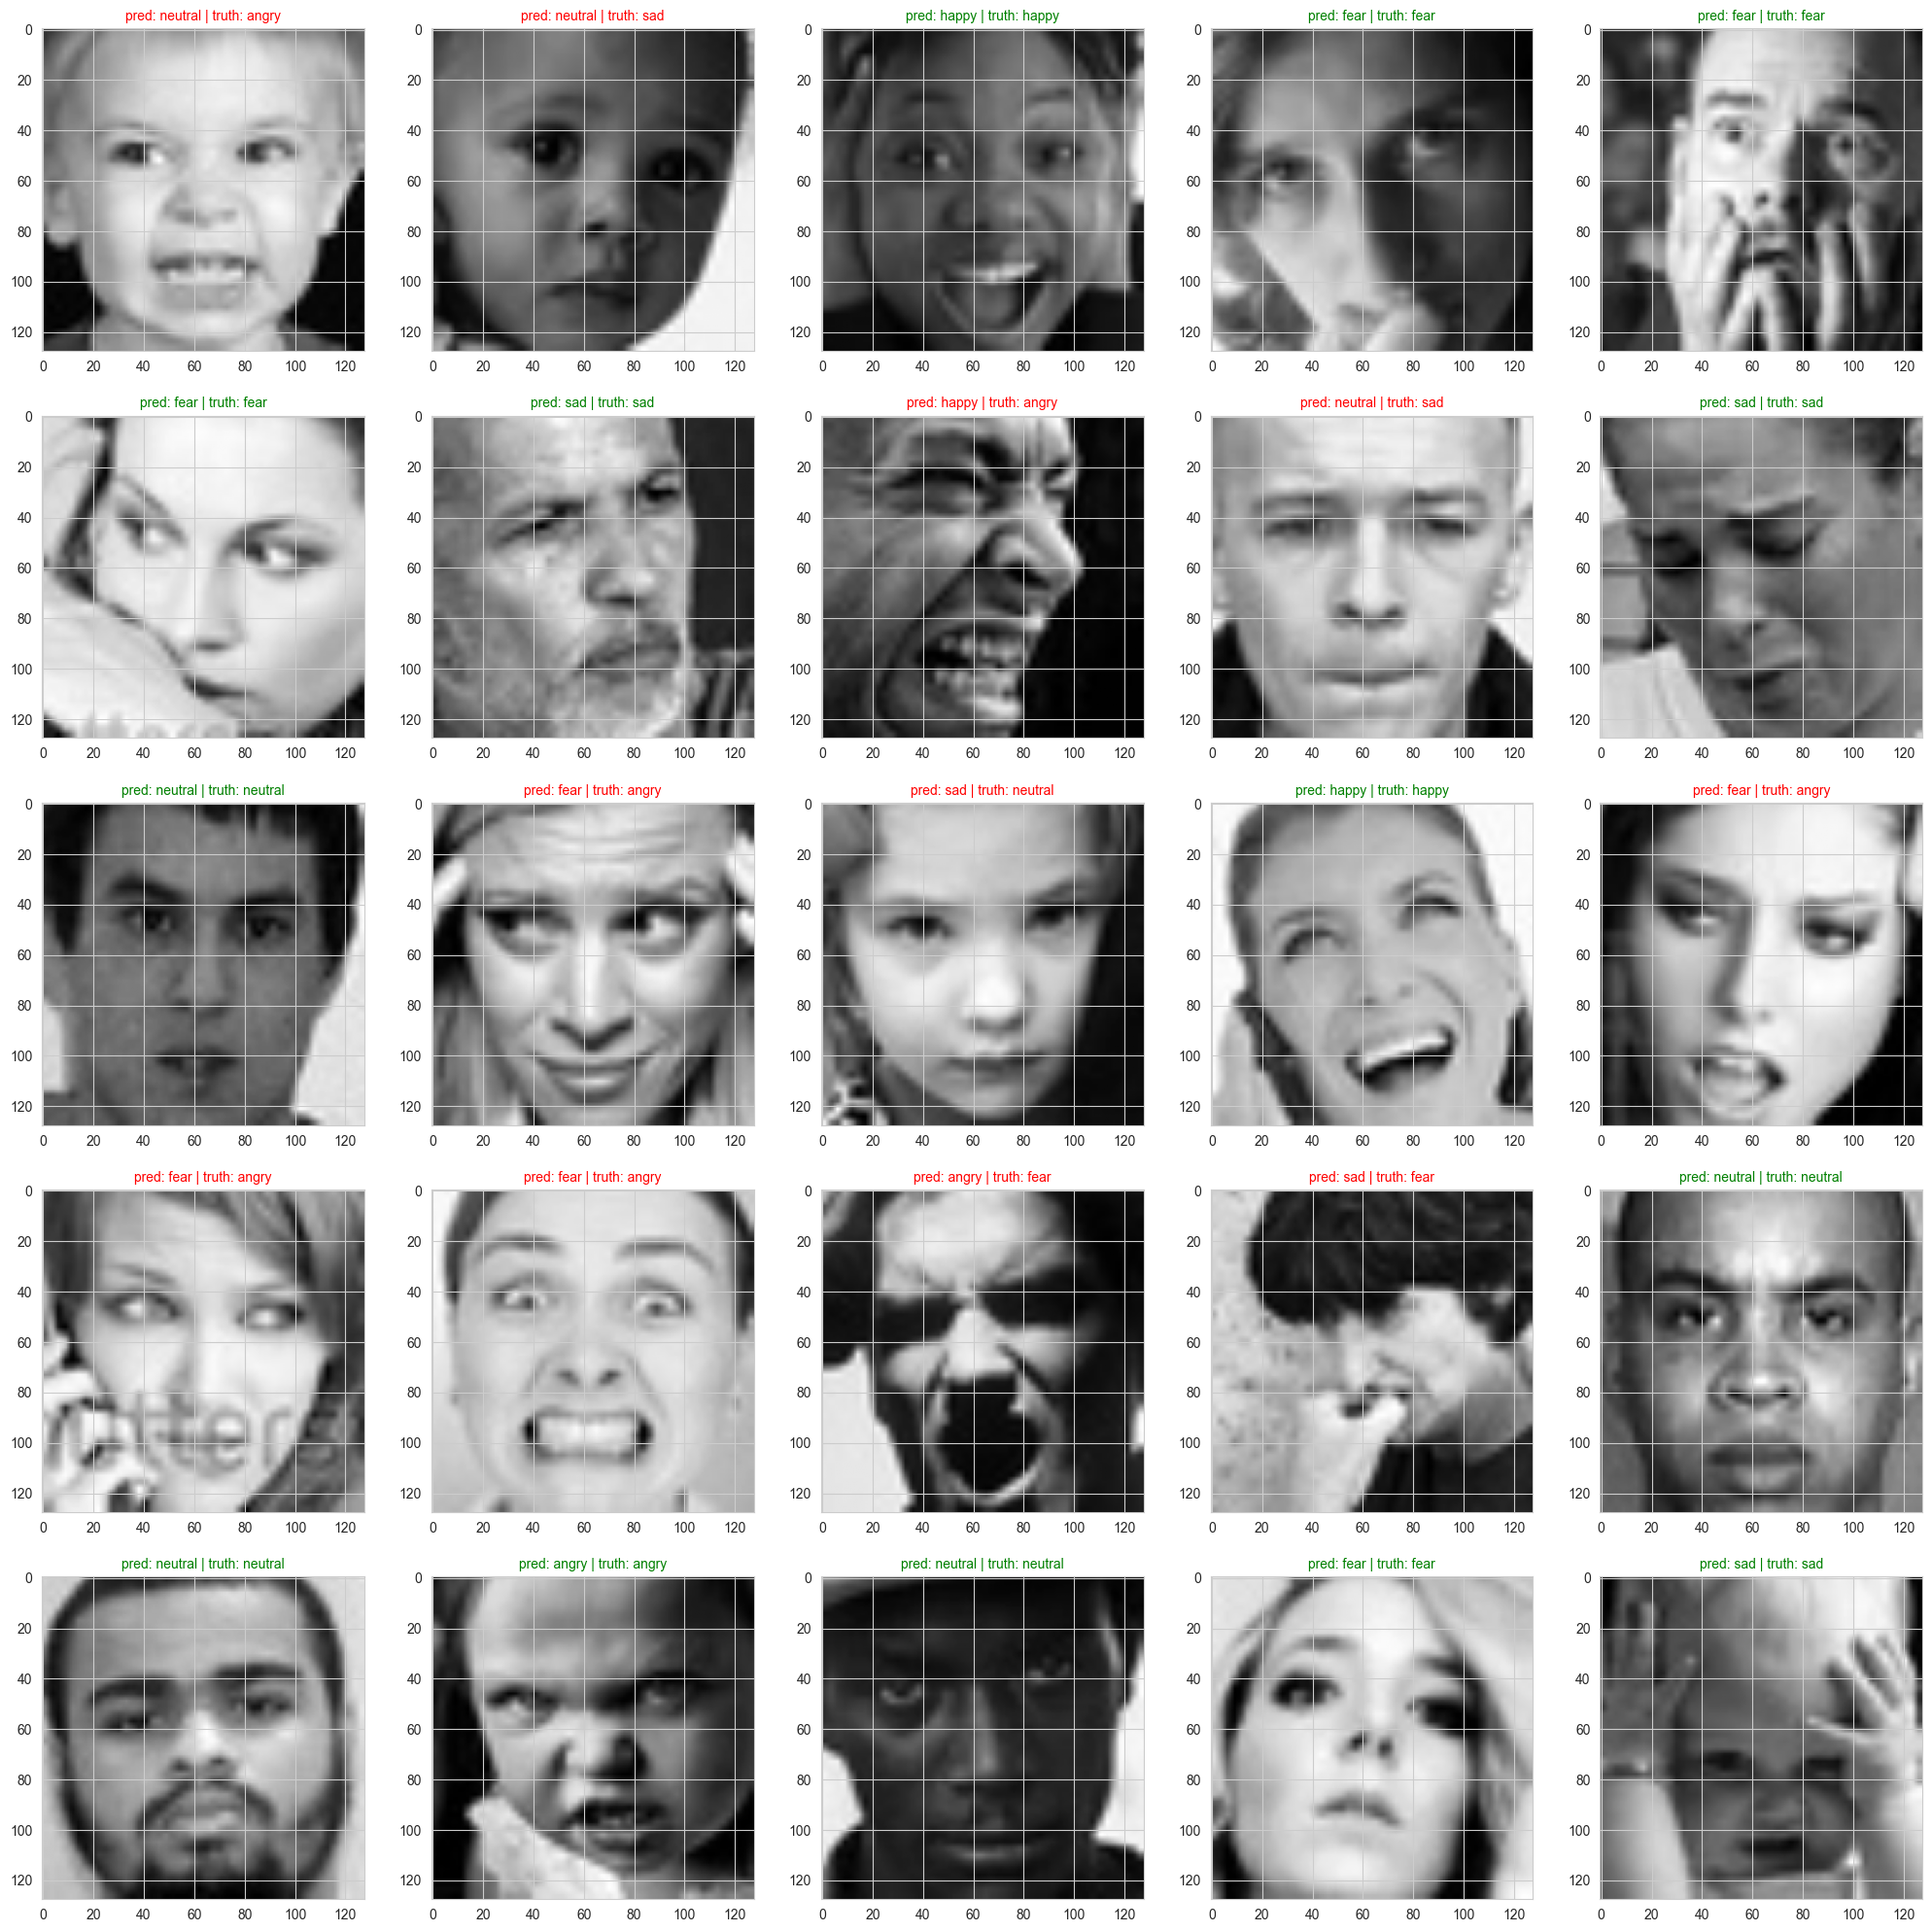

In [29]:
plt.figure(figsize=(25, 25))
nrows = 5
ncols = 5
for i, sample in enumerate(test_samples):
    # create subplot
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(sample.squeeze(), cmap="gray")  # squeeze for batch dimension
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title = f"pred: {pred_label} | truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title, fontsize=10, c="g")
    else:
        plt.title(title, fontsize=10, c="r")
plt.show()

In [30]:
torch.save(model.state_dict(), "fer_model.pth")